# Introduction to Deep Learning Final Project

## Facial Keypoint Detection Through CNN With Data Augmentation

For a part of this project, I will create a convolutional neural network (CNN) to perform facial identification by working through the [Facial Kepoints Detection Kaggle Competition](https://www.kaggle.com/competitions/facial-keypoints-detection/overview). I would like to work on AI navigation systems for spaceships someday, therefore the more computer vision-related things I can learn about, the better. To identify key features in faces, I will employ a supervised deep learning model.

Here is the overflow of the project:-

1. Download, Import and Inspect the data

2. Clean the data

3. Perform EDA

4. Build an initial CNN, evaluate it against validation

5. Perform hyper parameter optimization to improve results


### Libraries

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.layers import LeakyReLU
import os
import time

In [ ]:
#Make sure that tensorflow sees the GPU
tf.config.list_physical_devices('GPU')

[]

## Data Importation and Cleaning
Kaggle's amazing API is a great way to obtain the data for this project. I will manually unzip and place the data for this project in a folder called "data".

In [ ]:
os.getcwd()

'/content'

In [ ]:
#Confirm contents of "./data"
os.listdir("./data")

['training.zip', 'test.zip', 'SampleSubmission.csv', 'IdLookupTable.csv']

In [ ]:
training_df = pd.read_csv("./data/training.csv")
testing_df = pd.read_csv("./data/test.csv")

## Data Inspection
Let's examine the data size, shape, and types for our training and testing data before moving on to cleaning. I will examine the data's memory requirements using the os.path.size() function, give a summary of the training and test data using the pd.DataFrame.head() method and then explain a cleaning problem in a more understandable way using a hand snippet from the test.csv file.



In [ ]:
training_df.head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


In [ ]:
testing_df.head(1)

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...


In [ ]:
print("The total memory requirement for the training data is:", os.path.getsize("./data/training.csv")/1e6, "MB")
print("The total memory requirement for the testing data is:", os.path.getsize("./data/test.csv")/1e6, "MB")

The total memory requirement for the training data is: 238.06481 MB
The total memory requirement for the testing data is: 59.822141 MB


The project's data are extremely unorganised. The data are saved in non-rectangular.csv files, however, they encode faces in greyscale. They will require cleaning. Data from greyscale images are often represented as values that represent each pixel's brightness. Unlike RGB images, which call for three dimensions per pixel, there is only one datum per pixel in this case. Unfortunately, the actual image data are encoded as a single string of numbers. For clarification, consider this excerpt from the test dataset:

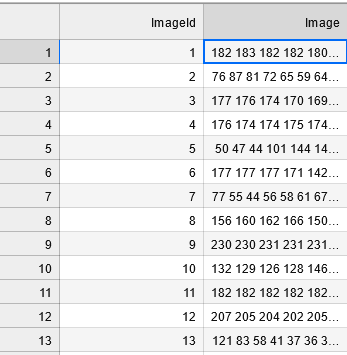

To convert the training and test data into a numpy ndarray that can be fed to Keras, we will need to create a custom parser. Because it contains every label we are looking for, the training dataset is slightly more rectangular. Nevertheless, the problem of needing a parser for the picture data persists. As an aside, a user is typically provided with a large number of real photographs while using computer vision. The cv2 library is an excellent resource for transforming images into useful image data. Its imread and resize functions are fantastic tools for turning data into a numpy.ndarray.<br><br>Before we rectangularize the datasets, lets first check for null values in the training data. The pd.DataFrame.info() method is an excellent way to see where null values are in a data frame.





In [ ]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          282 non-null    float64
 1   left_eye_center_y          282 non-null    float64
 2   right_eye_center_x         282 non-null    float64
 3   right_eye_center_y         282 non-null    float64
 4   left_eye_inner_corner_x    282 non-null    float64
 5   left_eye_inner_corner_y    282 non-null    float64
 6   left_eye_outer_corner_x    282 non-null    float64
 7   left_eye_outer_corner_y    282 non-null    float64
 8   right_eye_inner_corner_x   282 non-null    float64
 9   right_eye_inner_corner_y   282 non-null    float64
 10  right_eye_outer_corner_x   282 non-null    float64
 11  right_eye_outer_corner_y   282 non-null    float64
 12  left_eyebrow_inner_end_x   282 non-null    float64
 13  left_eyebrow_inner_end_y   282 non-null    float64

All but three of the columns in the training set have null values. Moreover, there are lots of features that only have values for $\frac{2271}{7049} \times 100\% = 32.2\%$ of their observations. The lack of labels would generally make these observations useless, but removing approximately seventy percent of our dataset is inane. We should instead use an imputation method. The pandas.fillna() method supplies us with a few different ways of imputing labels. We could either forward-fill or back-fill labels from the last/next valid observation using fillna(), which is akin to selecting a random legal value from the feature's probability density function. Another good method is to impute the mean value into each missing value.<br><br>It is important to take into account the modelling approaches that will be applied to the data while thinking about imputation strategies. The training data will be sent into a CNN that is connected to an ANN. As the most common (mode) observation in the training set, the worst case situation is that the ANN learns to simply predict the mean value for each imputed label. Therefore, I will use a back-fill imputation rather than a mean value imputation to preserve the diversity of our data. I will forward fill after backfilling to address any potential last-index missing value problems. The fact that the missing data are not properly spaced raises certain concerns because it could result in high counts of duplicated labels. Although we don't think this would happen, we can shuffle the data before imputing to make sure there are no non-independent rows.

In [ ]:
#Shuffle rows at random, then reset row  incapacity
training_df.sample(frac=1).reset_index(drop=True)
training_df.fillna(method = "bfill", inplace = True)
training_df.fillna(method = "ffill", inplace = True)
training_df.isnull().any().value_counts()

<ipython-input-35-9efb44f04447>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  training_df.fillna(method = "bfill", inplace = True)
<ipython-input-35-9efb44f04447>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  training_df.fillna(method = "ffill", inplace = True)


,count
False,31


We successfully inserted random, valid values into the training set. The picture data now needs to be corrected before being loaded into a numpy.ndarray for Keras.<br><br>Cleaning note: Some missing values in the picture feature are stored as null characters (''). I will map these to 128—the mean value for a greyscale image—in order to tidy them up. I don't think the ANN will start assuming 128 because these missing values aren't often.

In [ ]:
def cleanImages(images_series: pd.Series) -> np.ndarray:
    startTime = time.time()
    imgs = []
    expected_length = 96 * 96  # Expected number of pixels for a 96x96 image

    for img in images_series:
        these_pix_chrs = img.split(" ")
        these_pix_vals = [float(128) if j == "" else float(j) for j in these_pix_chrs]

        # Ensure all images have the same number of pixels
        if len(these_pix_vals) < expected_length:
            these_pix_vals.extend([128.0] * (expected_length - len(these_pix_vals)))
        elif len(these_pix_vals) > expected_length:
            these_pix_vals = these_pix_vals[:expected_length]

        imgs.append(these_pix_vals)

    # Convert images from list to numpy.ndarray
    np_images = np.array(imgs, dtype=np.float32)
    np_images = np_images.reshape((-1, 96, 96, 1))

    endTime = time.time()
    print("Total image conversion time:", round(endTime - startTime, 2), "seconds")

    return np_images

In [ ]:
training_images = cleanImages(training_df["Image"])
print("The resulting numpy.ndarray for the training data has shape:", training_images.shape)

Total image conversion time: 0.64 seconds
The resulting numpy.ndarray for the training data has shape: (282, 96, 96, 1)


In [ ]:
testing_images = cleanImages(testing_df["Image"])
print("The resulting numpy.ndarray for the test data has shape:", testing_images.shape)

Total image conversion time: 0.85 seconds
The resulting numpy.ndarray for the test data has shape: (284, 96, 96, 1)


Extract of the key points into a parallel numpy.ndarray to overlay the training images is the final step in the cleaning process. Although this is just necessary for the training set of data, I will include it in a function for any future projects that have similarly jumbled data.


In [ ]:
def getKeypoints(training_data : pd.DataFrame) -> np.ndarray:
    #Extract keypoints from training data
    ## The keypoint features are all features in the training dataset that aren't the image data
    startTime = time.time()
    training_data = training_data.drop("Image", axis = 1)
    keypoints = list()

    for index, string_keypoints in training_data.iterrows():
        keypoints.append(string_keypoints)

    #Convert keypoints to float, and store in ndarray
    keypoints = np.array(keypoints, dtype = "float")
    endTime = time.time()
    print("Total keypoint extraction time:", round(endTime - startTime, 2), "seconds")

    return(keypoints)

In [ ]:
training_keypoints = getKeypoints(training_df)
print("The resulting numpy.ndarray has shape:", training_keypoints.shape)

Total keypoint extraction time: 0.02 seconds
The resulting numpy.ndarray has shape: (282, 30)


## EDA and Augmentation
I will carry out EDA while I work on data augmentation for my model to ensure that both I and my reader are aware of the true appearance of the photos I am modelling. Let's start by viewing a few faces with keypoints from the training set superimposed on them.

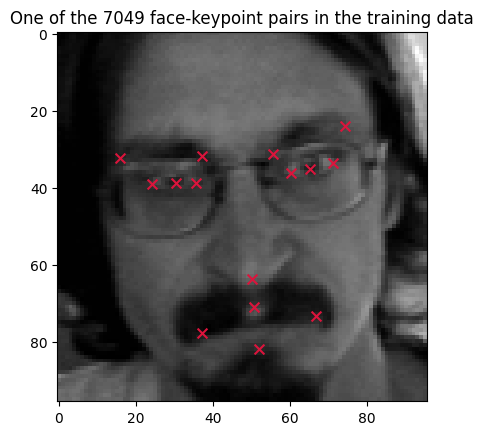

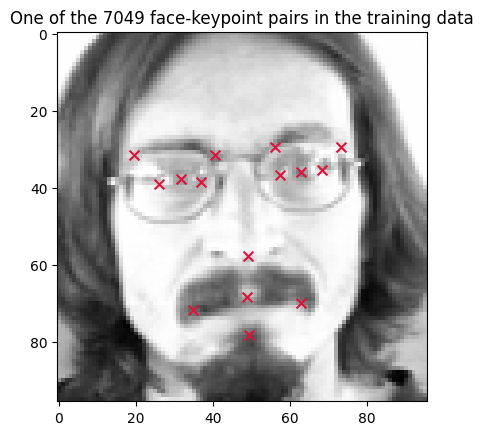

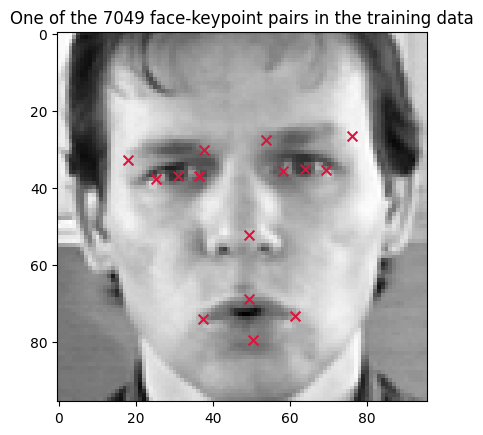

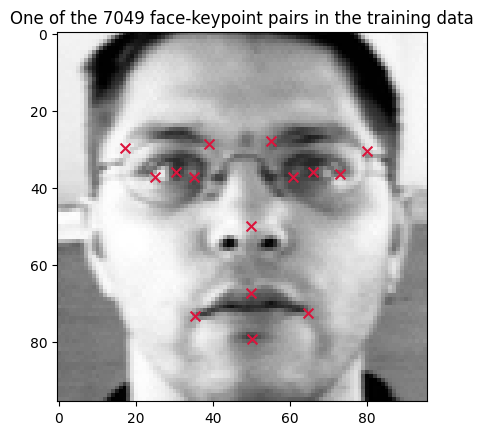

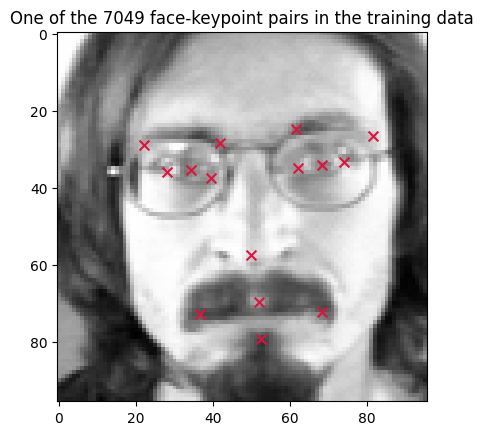

In [ ]:
import random

for i in range(5):
    idx = random.randrange(0, training_images.shape[0])
    fig, axis = plt.subplots()
    this_img = training_images[idx].reshape(96, 96)
    axis.imshow(this_img, cmap = "gray")
    axis.scatter(training_keypoints[idx][0::2], training_keypoints[idx][1::2], c = "crimson", marker = "x", s = 50)
    plt.title("One of the 7049 face-keypoint pairs in the training data")

Because they are estimated from other data, some of the keypoints are inaccurate (I am referring to the first male). I hope these misses average out to a correct forecast over a large amount of training data and weight adjustments.<br><br>We discovered in class that feeding a neural network with a variety of potential image orientations is an effective method of training it to generalise the distribution of image data. People pose in a variety of ways for pictures, therefore we should prepare our model for every orientation that might be required. To be clear, we plan to add translations and rotations to our dataset from the original dataset. Of course, we will use the same map to highlight the important spots when the images are translated and rotated.

In [ ]:
# Make image and keypoint rotation augmenter
import cv2
import math

def rotationAugment(train_imgs : np.ndarray, train_keys : np.ndarray, rotationAngles : list):
    """
        This function rotates the inputs. We will use np.concatenate to augment the training data.
        The rotations performed are both clockwise and anticlockwise in degrees, read from rotationAngles.

        Output: (np.ndarray rotated_imgs, np.ndarray rotated_keys)
    """
    rotated_imgs = list()
    rotated_keys = list()

    for abs_theta in rotationAngles:
        both_directions = [-abs_theta, abs_theta]
        for theta in both_directions:
            # Convert angle in degrees to radians. cv2 apparantly uses a non-conventional
            ## rotation convention where clockwise is positive, so we need a negative.
            theta_in_radians = -1 * theta * math.pi / 180
            #Create rotation matrix for warpAffine
            R = cv2.getRotationMatrix2D((48, 48), theta, 1.0)

            #Rotate all training images
            for img in train_imgs:
                this_rotated_img = cv2.warpAffine(img, R, (96, 96), flags = cv2.INTER_CUBIC)
                rotated_imgs.append(this_rotated_img)

            #Rotate all training keypoints
            for keypts in train_keys:
                # We cant just rotate every pixel against the cv2 MAT for the keypoints,
                ## so we will need to do this manually. First, we center the keypoints about 0.
                rotated = keypts - 48
                for index in range(0, len(rotated), 2):
                    rotated[index] = rotated[index] * math.cos(theta_in_radians) - rotated[index + 1] * math.sin(theta_in_radians)
                    rotated[index + 1] = rotated[index + 1] * math.cos(theta_in_radians) + rotated[index] * math.sin(theta_in_radians)
                rotated = rotated + 48

                rotated_keys.append(rotated)

    rotated_imgs = np.array(rotated_imgs)
    rotated_imgs = rotated_imgs.reshape(-1, 96, 96, 1)
    rotated_keys = np.array(rotated_keys)

    return (rotated_imgs, rotated_keys)

In [ ]:
startTime = time.time()
# Perform rotation by -15, 15 degrees.
rotation_angles = [15]
(rotated_train_imgs, rotated_train_keypoints) = rotationAugment(training_images, training_keypoints, rotation_angles)

# The resulting dataframe will have 5 times as many observations as we started with.
## We will combine our training dataframes so that our translations will also have a 4/5 chance to
### be rotations.
training_images = np.concatenate((training_images, rotated_train_imgs))
print("After appending the rotations, the training images has shape:", training_images.shape)
training_keypoints = np.concatenate((training_keypoints, rotated_train_keypoints))
print("After appending the rotations, the training keypoints has shape:", training_keypoints.shape)

endTime = time.time()
print("Total rotation augmentation time:", round(endTime - startTime, 2), "seconds")

After appending the rotations, the training images has shape: (846, 96, 96, 1)
After appending the rotations, the training keypoints has shape: (846, 30)
Total rotation augmentation time: 0.95 seconds


## Analysis:
Let's have a look at a few of the new upgraded training_images for the purpose of EDA. Each image is now available in five copies, each with a rotation on the set $\{-15, 0, 15\}$ degrees. These gentle rotations should be representative of what the model could experience in the training set. I will choose five images at random to plot, just like I used to.

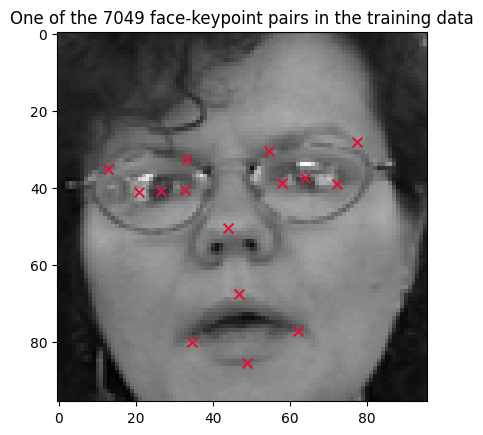

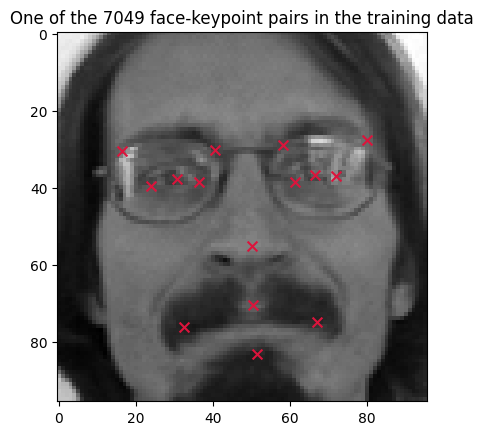

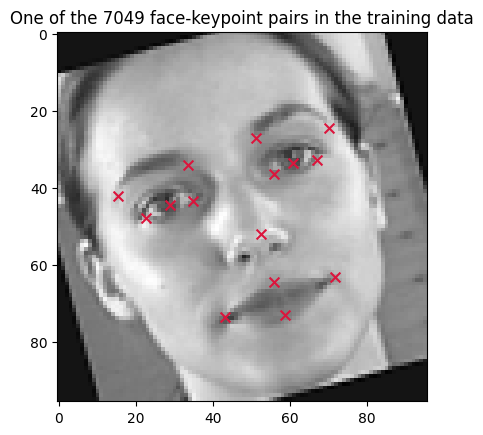

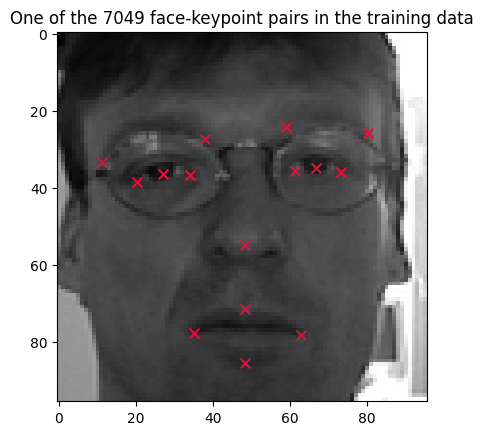

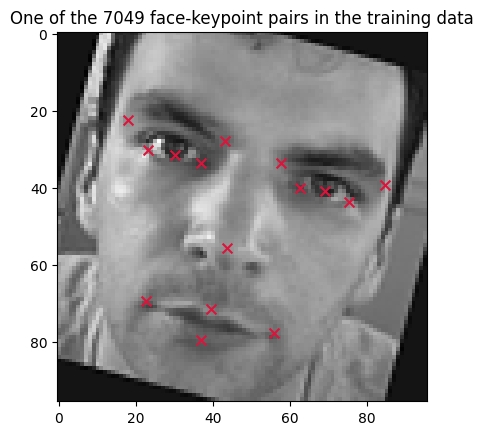

In [ ]:
for i in range(5):
    idx = random.randrange(0, training_images.shape[0])
    fig, axis = plt.subplots()
    this_img = training_images[idx].reshape(96, 96)
    axis.imshow(this_img, cmap = "gray")
    axis.scatter(training_keypoints[idx][0::2], training_keypoints[idx][1::2], c = "crimson", marker = "x", s = 50)
    plt.title("One of the 7049 face-keypoint pairs in the training data")

To further diversity the training data, I will now apply linear translations to each image. Although we may perform many other augmentations on the data, I believe that rotation and translation working together are sufficient for this purpose. Reshading, noising up and horizontal flips are some other potential augmentations.



In [ ]:
def translationAugment(train_imgs : np.ndarray, train_keys : np.ndarray, translation_distances : list):
    """
        This function creates translated images. The input images train_imgs will be mapped d
        pixels diagonally from their start position in each of four diagonal directions.
        Output: (np.ndarray translated_imgs, np.ndarray translated_keys)
    """
    translated_imgs = list()
    translated_keys = list()
    for d in translation_distances:
        #Translate in all four diagonal directions
        all_translations = [(-d, -d), (-d, d), (d, -d), (d, d)]
        for translation in all_translations:
            #Create image translation matrix for warpAffine
            T = np.array([[1, 0, translation[0]], [0, 1, translation[1]]], dtype = "float32")

            # This line courtesy of balraj. We can zip together train_imgs and train_keys
            ## to avoid the need for playing with indecies. Much cleaner than my initial implementation
            for (img, keypts) in zip(train_imgs, train_keys):
                this_translated_img = cv2.warpAffine(img, T, (96, 96), flags = cv2.INTER_CUBIC)

                """
                We want to translate the x_coordinate keypoints horizontally, and y_coordinate
                keypoints vertically. The even columned keypoints are x coordinates, while the
                odd columned keypoints are y coordinates. We can use the % operator:
                """
                these_translated_keypts = [(keypt + translation[0]) if (col_id % 2 == 0) else (keypt + translation[1]) for (col_id, keypt) in enumerate(keypts)]
                these_translated_keypts = np.array(these_translated_keypts)

                # We don't want translations that result in the keypoints being mapped outside of
                ## the (96, 96) grid, so we will filter any badly behaved translations out.
                if np.all(these_translated_keypts > 0.0) and np.all(these_translated_keypts < 96.0):
                    this_translated_img = this_translated_img.reshape(96, 96, 1)
                    translated_imgs.append(this_translated_img)
                    translated_keys.append(these_translated_keypts)

    return (translated_imgs, translated_keys)

In [ ]:
startTime = time.time()
# Translate in all four legal diagonal directions by 15 pixels
dist = [15]
(translated_train_imgs, translated_train_keys) = translationAugment(training_images, training_keypoints, dist)

training_images = np.concatenate((training_images, translated_train_imgs))
print("After appending the rotations, the training images has shape:", training_images.shape)
training_keypoints = np.concatenate((training_keypoints, translated_train_keys))
print("After appending the rotations, the training keypoints has shape:", training_keypoints.shape)

endTime = time.time()
print("Total translation augmentation time:", round(endTime - startTime, 2), "seconds")

After appending the rotations, the training images has shape: (2677, 96, 96, 1)
After appending the rotations, the training keypoints has shape: (2677, 30)
Total translation augmentation time: 0.74 seconds


## Analysis:
With this amount of training data, we should have enough to work with. With 61,323 training photos at our disposal, we can feed our neural network. I will display a random sample of the data, just as I did following the implementation of the rotation augment. Less than 4/5 of the images will have some translation from the source, and precisely 2/3 will be rotated.



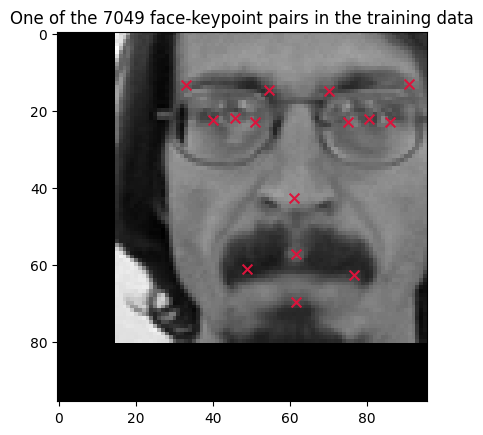

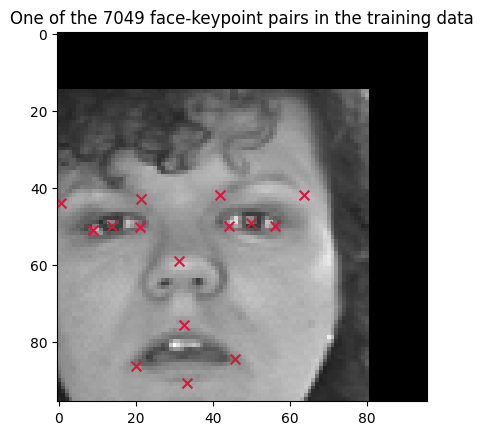

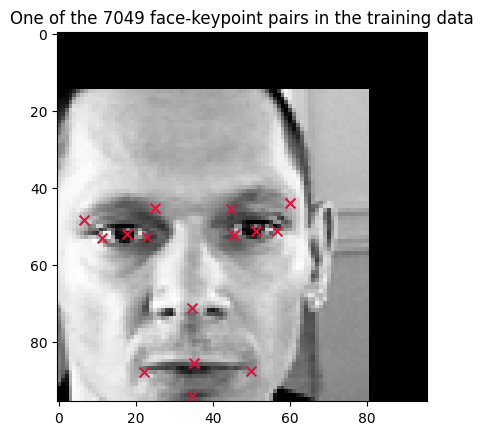

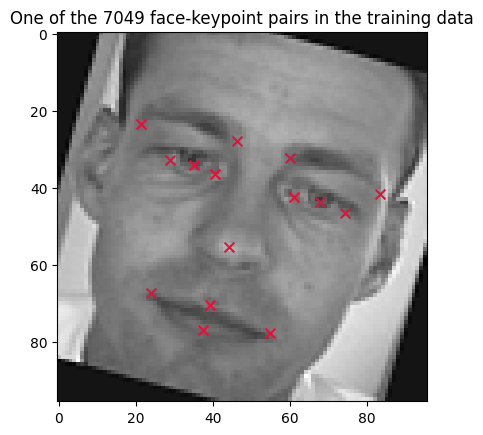

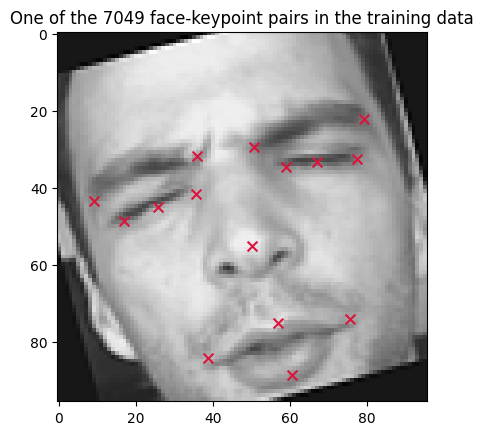

In [ ]:
for i in range(5):
    idx = random.randrange(0, training_images.shape[0])
    fig, axis = plt.subplots()
    this_img = training_images[idx].reshape(96, 96)
    axis.imshow(this_img, cmap = "gray")
    axis.scatter(training_keypoints[idx][0::2], training_keypoints[idx][1::2], c = "crimson", marker = "x", s = 50)
    plt.title("One of the 7049 face-keypoint pairs in the training data")

We will restrict the quantity of training data the model sees as a last cleaning step. Since the "normal" photographs are the most indicative of what we are likely to see in the test set, we want to include all of them. I will also be including roughly 8000 randomly chosen augmented photos.

In [ ]:
n_augmented_samples = 15000 - 7049
normal_imgs = training_images[:7049, :, :, :]
normal_keypts = training_keypoints[:7049, :]
n_augmented = training_images.shape[0] - 7049
augmented_indices = np.random.permutation(n_augmented) + 7049
selected_augmented_indices = augmented_indices[:n_augmented_samples]
augmented_imgs = training_images[selected_augmented_indices, :, :, :]
augmented_keypts = training_keypoints[selected_augmented_indices, :]
training_images = np.concatenate((normal_imgs, augmented_imgs))
training_keypoints = np.concatenate((normal_keypts, augmented_keypts))

In [ ]:
print("Final training images shape:", training_images.shape)
print("Final training keypoints shape:", training_keypoints.shape)

Final training images shape: (2677, 96, 96, 1)
Final training keypoints shape: (2677, 30)


## Model Building and Architecture:
Two parts will make up the model I will employ to predict keypoints: a CNN-style feature extractor and a Dense ANN-style label creator. We discovered in class that iterating through three layers is the normal process for developing a convolutional feature extractor:
$$[\text{Convolve}, \text{Convolve}, \text{MaxPool}]_n$$
<br>The next step involves repeating this set of three layers a certain number of times. This architecture selection is a hyperparameter that needs to be maximised. In a convolution layer, a simple mathematical operation is applied to the pixels surrounding a central pixel and the resultant value is recorded as a weight that corresponds to the original pixel. Then, every pixel in the supplied image goes through this procedure once again. In order to "blur" local features for upcoming convolution layers, the MaxPool operation serves as a filter. This helps pick up global features and helps handle chaotic images. Because the succeeding convolution layers will be conducting convolution on already convolved features, which were in turn functions of local features, they will draw from "farther" features relative to the original image as [C, C, MP] iterations grow. Many local traits combine to form a greater global feature. Since we are dealing with facial image data, we want the ANN to "see" the full image before allocating points.<br><br>I am going to place BatchNormalization layers after each convolution layer to keep the weights from diverging. An input is mapped by a batch normalisation layer to a Standard Normal variable, which is then used for convolution calculations. It is better to work with smaller, more balanced values while doing addition and multiplication.<br><br>For this project, I will experiment with multiple topologies and learning rates as part of my hyperparameter optimisation approach. I will only use the "Adam" optimiser to save training time, although "RMSprop" is also a useful optimiser that can be found in the Keras library. Please feel free to give it a try instead and compare the outcomes.

## Initial Model:
To get started, I will use four [C, C, MP] iterations, each with twice as many filters as the layer before it. LeakyReLU activations are what I will employ because, as our professor pointed out, they allow for greater output diversity for negative valued inputs. It uses a hyperparameter, LeakyReLU $\alpha$, which, once I have chosen my architecture, I will experiment with.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, LeakyReLU, Input

def makeCNN(initial_eta: float, initial_filter_num: int, num_CCMP_layers: int):
    """
    This function creates and compiles, but does not train, a CNN -> ANN model to
    process the training data and predict keypoints.
    Input:
        learning rate initial_eta, strictly greater than 0
        initial filter count initial_filter_num, should be multiple of 2
        number of C-C-MP iterations, must be 1 <= k <= 5
    Output:
        Compiled keras.Sequential model
    """
    # Set initial HP's
    in_shape = (96, 96, 1)
    pad = "same"
    ker_size = 3
    cntr = 2

    # Initialize model
    model = Sequential()

    # Add initial C-C-MP layer
    model.add(Input(shape=in_shape))
    model.add(Conv2D(initial_filter_num, ker_size, padding=pad, use_bias=False))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(initial_filter_num, ker_size, padding=pad, use_bias=False))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    # Add the desired number of C-C-MP layers
    for layer in range(num_CCMP_layers - 1):
        model.add(Conv2D(cntr*initial_filter_num, ker_size, padding=pad, use_bias=False))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())
        model.add(Conv2D(cntr*initial_filter_num, ker_size, padding=pad, use_bias=False))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())
        model.add(MaxPooling2D())
        cntr *= 2

    # Add ANN for keypoint assignment
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.15))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.15))
    model.add(Dense(30))  # Output layer for 15 keypoints (x, y coordinates)

    # Add learning rate scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_eta,
        decay_steps=1000,
        decay_rate=0.9
    )

    # Compile model with appropriate callbacks
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="mean_squared_error",
        metrics=["mae"]
    )

    return model

In [ ]:
# Fit initial model as sanity check before performing grid search over H.P.'s
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min")]

# SPEED IMPROVEMENT: Increase initial_eta to 5e-3 or 1e-2, reduce initial_filter_num to 8, reduce num_CCMP_layers to 2
testModel = makeCNN(5e-3, 8, 2)

subset_size = min(5000, len(training_images))  # Adjust this number as needed
subset_indices = np.random.choice(len(training_images), subset_size, replace=False)
subset_images = training_images[subset_indices]
subset_keypoints = training_keypoints[subset_indices]

testHistory = testModel.fit(subset_images, subset_keypoints,
                            validation_split=0.05,
                            epochs=3,
                            batch_size=64,
                            callbacks=callbacks_list,
                            verbose=2
                           )

Epoch 1/3
40/40 - 42s - 1s/step - loss: 422.4379 - mae: 14.9339 - val_loss: 551.2298 - val_mae: 19.8512
Epoch 2/3
40/40 - 36s - 892ms/step - loss: 115.4782 - mae: 8.3778 - val_loss: 484.0521 - val_mae: 19.2916
Epoch 3/3
40/40 - 44s - 1s/step - loss: 85.6169 - mae: 7.1766 - val_loss: 287.4639 - val_mae: 14.7083


## Analysis:
The model functions! It is somewhat bouncy when it comes to validation loss, though, thus we might have to utilise some other callbacks instead of simply a patience option. In order to avoid storing versions of the model that are worse, I will employ a checkpointer. With a basic model up and running, we can begin the process of hyperparameter optimisation. I will verify the values of $\eta$ on the set $\{10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}\}$. It's possible that we could invest a lot of computational effort in optimising $\eta$, yet it doesn't seem worth it given how long a single training cycle takes.<br><br> Another thing I will do is maximise the number of [C-C-MP] layers, which can have values between 1 and 5 before the convolution space gets odd (3 X 3) and prevents a 2X2 filter from being properly MaxPooled.



In [ ]:
startTime = time.time()

# Reduce model complexity
optimal_model = makeCNN(0.002, 16, 2)  # Increased learning rate, reduced filters and layers

# Reduce patience for early stopping
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")]

# Use a subset of the data
subset_size = min(10000, len(training_images))
subset_indices = np.random.choice(len(training_images), subset_size, replace=False)
subset_images = training_images[subset_indices]
subset_keypoints = training_keypoints[subset_indices]

optimal_history = optimal_model.fit(subset_images, subset_keypoints,
                        validation_split=0.1,
                        epochs=50,
                        batch_size=64,
                        callbacks=callbacks_list,
                        verbose=1
                        )

print("Here's the model summary for the optimal model:")
optimal_model.summary()
endTime = time.time()
print("Total training time for optimal model was:", round((endTime - startTime)/60, 2), "minutes")

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 799.6741 - mae: 21.2521 - val_loss: 745.3134 - val_mae: 19.8545
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - loss: 144.4000 - mae: 9.4220 - val_loss: 202.5529 - val_mae: 11.2105
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - loss: 111.2804 - mae: 8.2253 - val_loss: 204.6934 - val_mae: 12.0673
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - loss: 96.7138 - mae: 7.6452 - val_loss: 153.6931 - val_mae: 10.6013
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - loss: 85.8781 - mae: 7.1863 - val_loss: 174.4405 - val_mae: 11.0946
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - loss: 100.6884 - mae: 7.6514 - val_loss: 117.3835 - val_mae: 9.3392
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - loss: 78.8115 - mae: 6.7907 - val_loss: 33.6377 - val_mae: 4.5579
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - loss: 66.4702 - mae: 6.2776 - val_loss: 52.8349 - val_mae: 5.9207
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 7

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)                   │ (None, 96, 96, 16)          │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_54 (LeakyReLU)           │ (None, 96, 96, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 96, 96, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 96, 96, 16)          │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_55 (LeakyReLU)           │ (None, 96, 96, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 96, 96, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 48, 48, 32)          │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_56 (LeakyReLU)           │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 48, 48, 32)          │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_57 (LeakyReLU)           │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,316,427 (54.61 MB)

 Trainable params: 4,772,078 (18.20 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 9,544,157 (36.41 MB)

Total training time for optimal model was: 39.37 minutes


## Results and Analysis:
Let's start by creating some visuals to show how effectively the model worked with the training and validation sets of data. Next, using the test set as a guide, we will create predictions and submit them to Kaggle for evaluation.


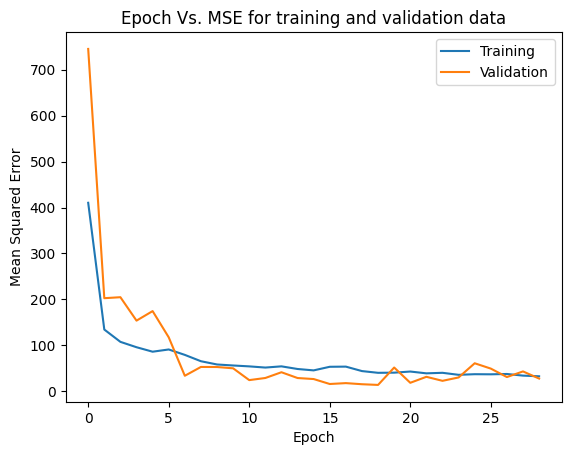

In [ ]:
# Plot MSE and Val_MSE vs. Epoch
plt.plot(optimal_history.history["loss"])
plt.plot(optimal_history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Epoch Vs. MSE for training and validation data")
plt.legend(["Training", "Validation"])
plt.show()

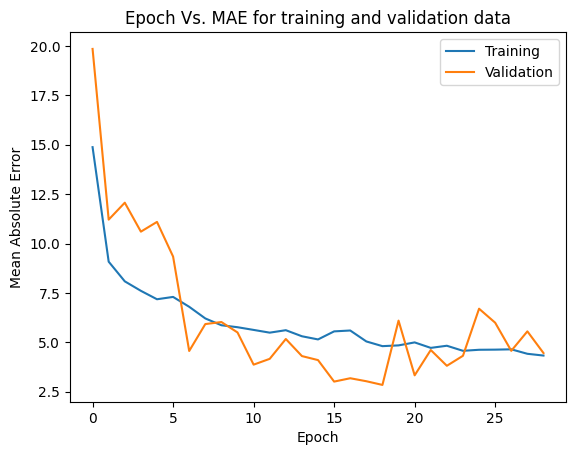

In [ ]:
# Plot MAE and Val_MAE vs. Epoch
plt.plot(optimal_history.history["mae"])
plt.plot(optimal_history.history["val_mae"])
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.title("Epoch Vs. MAE for training and validation data")
plt.legend(["Training", "Validation"])
plt.show()

## Analysis:
Regarding the plots, it should be noted that an accuracy is only considered a "hit" when the model produces the precise right pixel for the keypoint. Many of the keypoint labels were imputed from other data and the labels were already somewhat hazy. For pixel-perfect assignments, a final accuracy of roughly 70% is perfectly acceptable. Since the MAE and MSE are valid minimizable loss functions and show how close the model is to the target, they are more reasonable statistics to be concerned with. It is ideal for the MAE and MSE to asymptote down for the validation data because of the learning rate scheduling. At the conclusion of training, the model's MAE was only roughly 2 pixels, which is good. Since by the time training completed, none of the validation measures had started to decline, we could have probably allowed the training to continue. There had been forty minutes of instruction in total.

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step
Sanity check - the predicted keypoints have shape: (284, 30)


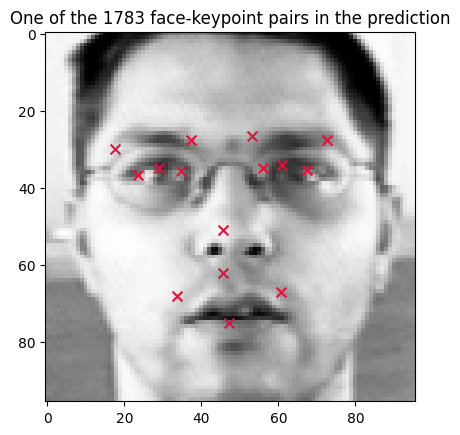

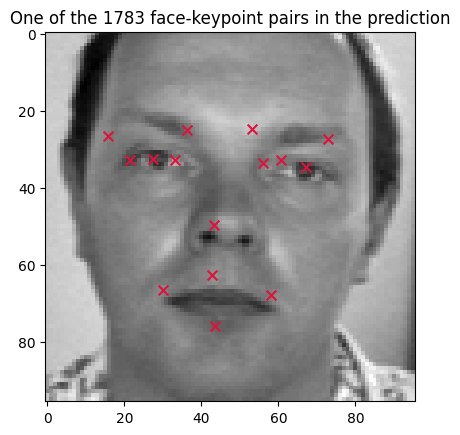

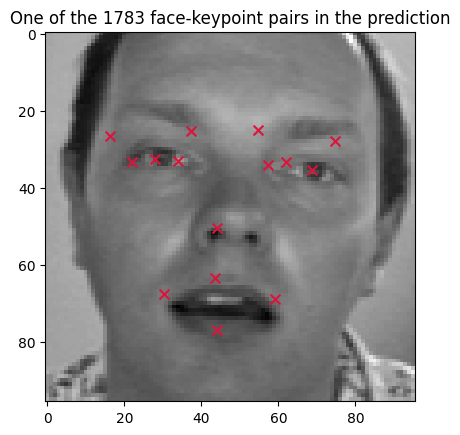

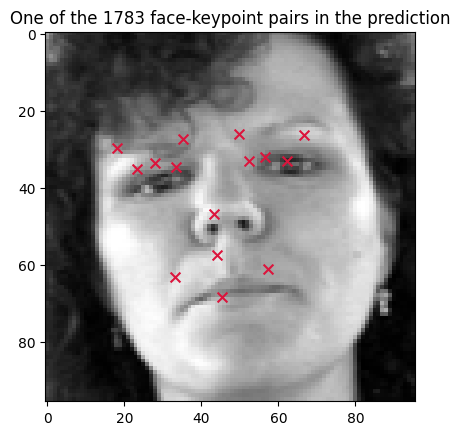

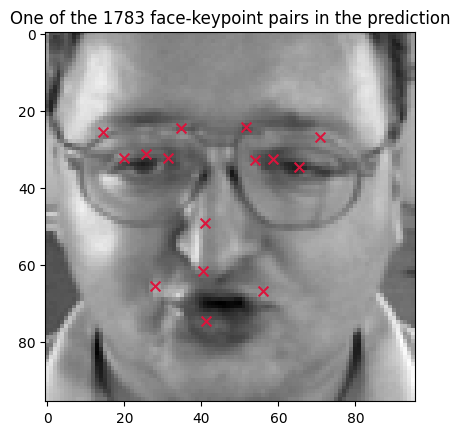

In [ ]:
pred_keypoints = optimal_history.model.predict(testing_images)
print("Sanity check - the predicted keypoints have shape:", pred_keypoints.shape)
# Visualize the predictions
for i in range(5):
    idx = random.randrange(0, testing_images.shape[0])
    fig, axis = plt.subplots()
    this_img = testing_images[idx].reshape(96, 96)
    axis.imshow(this_img, cmap = "gray")
    axis.scatter(pred_keypoints[idx][0::2], pred_keypoints[idx][1::2], c = "crimson", marker = "x", s = 50)
    plt.title("One of the 1783 face-keypoint pairs in the prediction")

## Random Forest



In [ ]:
from sklearn.ensemble import RandomForestRegressor
startTime = time.time()
forest_train_data = training_images.reshape(training_images.shape[0], 96 * 96)
forest_test_data = testing_images.reshape(testing_images.shape[0], 96 * 96)
reg = RandomForestRegressor(n_estimators = 100,
                            max_depth = 3,
                            random_state = 42,
                            n_jobs = 8
                           )
reg.fit(forest_train_data, training_keypoints)

RF_preds = reg.predict(forest_test_data)
endTime = time.time()
print("Total random forest regressor training time was", round((endTime - startTime)/60, 2), "minutes")

Total random forest regressor training time was 10.59 minutes


Sanity check - the predicted keypoints have shape: (284, 30)


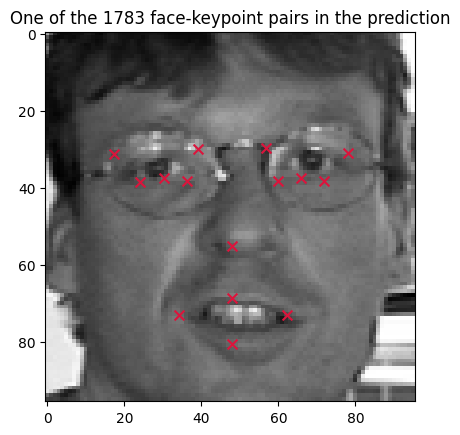

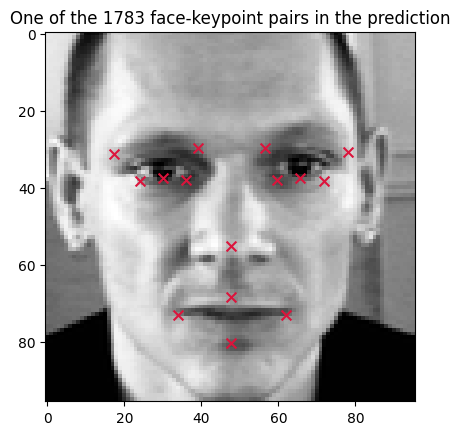

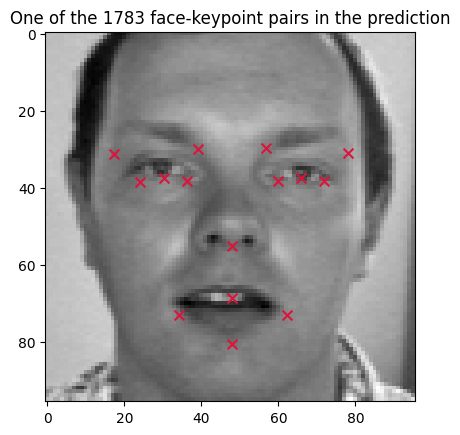

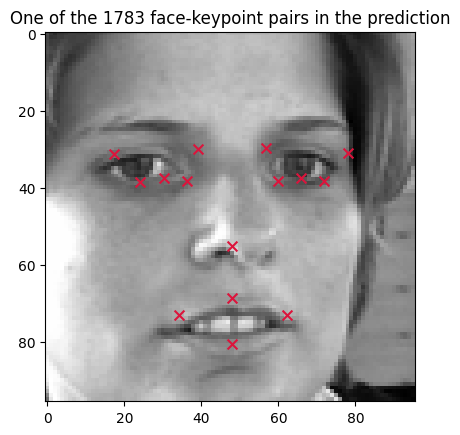

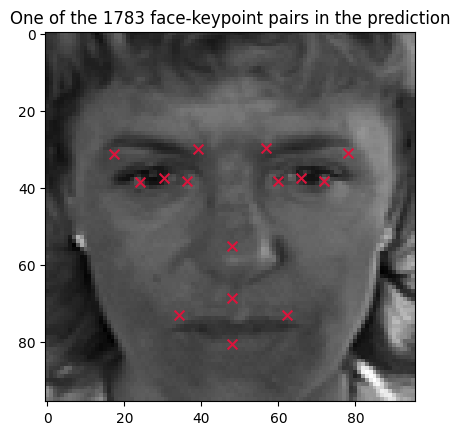

In [ ]:
# Visualize predictions from random forest regressor
print("Sanity check - the predicted keypoints have shape:", RF_preds.shape)
# Visualize the predictions
for i in range(5):
    idx = random.randrange(0, testing_images.shape[0])
    fig, axis = plt.subplots()
    this_img = testing_images[idx].reshape(96, 96)
    axis.imshow(this_img, cmap = "gray")
    axis.scatter(RF_preds[idx][0::2], RF_preds[idx][1::2], c = "crimson", marker = "x", s = 50)
    plt.title("One of the 1783 face-keypoint pairs in the prediction")

# Analysis:
The random forest appears to consistently produce the same forecasts. This is essentially a null model in which the mean value of each attribute is simply estimated. For facial recognition, this kind of forecast is practically meaningless. For making decisions, the neural network is consequently strongly favoured. While we might attempt to expand the size of the random forest, accuracy is unlikely to converge nearly as quickly as that of the neural network. I would rather improve the neural network through computing time.

# Conclusion:
This project acted as my introduction to facial recognition technology. As a feature extractor, I constructed a convolutional neural network and as a regressor for face important points, I attached it to an artificial neural network. The network performed admirably in recognising eyes and eyebrows, but it struggled to recognise the edges of lips and the points of noses. There is a chance that this error resulted from the various ways people pose for pictures. People will sometimes close their jaws and occasionally smile. When having their photo taken, most people usually have their eyes open.<br><br>The neural network performed admirably despite its flaws. As my experiment came to an end, I compared my AI to a random forest regressor. Based on the photos that were presented to it, the random forest completely failed to generate adaptive keypoints. It appears that the null model, or mean value of each feature for each image, is all that the random forest can guess. Future improvements to the nueral network could include longer training times, more enhanced data, and a wider variety of augmentations.

# Bibliography:
[Missing Value Imputation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)